In [1]:
%pylab inline
from scipy import ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import sys
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.gridspec as gridspec

sys.path.append('../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from joblib import Parallel, delayed
import multiprocessing
import pickle
import gzip

def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

Populating the interactive namespace from numpy and matplotlib


In [2]:
results_1 = pickle.load(gzip.open('results/trace_L1_results.gz', 'rb'))
results_2 = pickle.load(gzip.open('results/isotropic_L1_results.gz', 'rb'))
results_3 = pickle.load(gzip.open('results/trace_TV_results.gz', 'rb'))
results_4 = pickle.load(gzip.open('results/isotropic_TV_results1.gz','rb'))
results_5 = pickle.load(gzip.open('results/isotropic_TV_results2.gz','rb'))

results = [results_1, results_2,results_3,results_4,results_5]
#Phi_labels = [r"$\Vert \sigma_{xz} + \sigma_{yz}\Vert_1$",
#              r"$\Vert \sigma_{xz} \Vert_1 + \Vert \sigma_{yz} \Vert_1$",
#              r"$\Vert \nabla(\sigma_x+\sigma_y )\Vert_1$",
#              r"$\Vert (\partial_x + \partial_y)\sigma_x \Vert_1 + \Vert\partial_x+\partial_y)\sigma_y \Vert_1$",
#              r"$\Vert \partial_x \sigma_x \Vert_1 + \Vert \partial_y \sigma_x \Vert_1 + \Vert\partial_x \sigma_y\Vert_1 + \Vert\partial_y \sigma_y\Vert_1$"
#             ]

Phi_labels = [r"$\Phi_{L^1(Tr)}$",
             r"$\Phi_{L^1}$",
             r"$\Phi_{TV(Tr)}$",
             r"$\Phi_{TV_1}$",
             r"$\Phi_{TV_2}$"]


In [3]:
x_1 = results_1[-1][0]
y_1 = results_1[-1][1]
for rel in results: del(rel[-1])
x_min, x_max = 69.974999999999994, 133.72999999999999
y_min, y_max = 139.94999999999999, 189.71000000000001

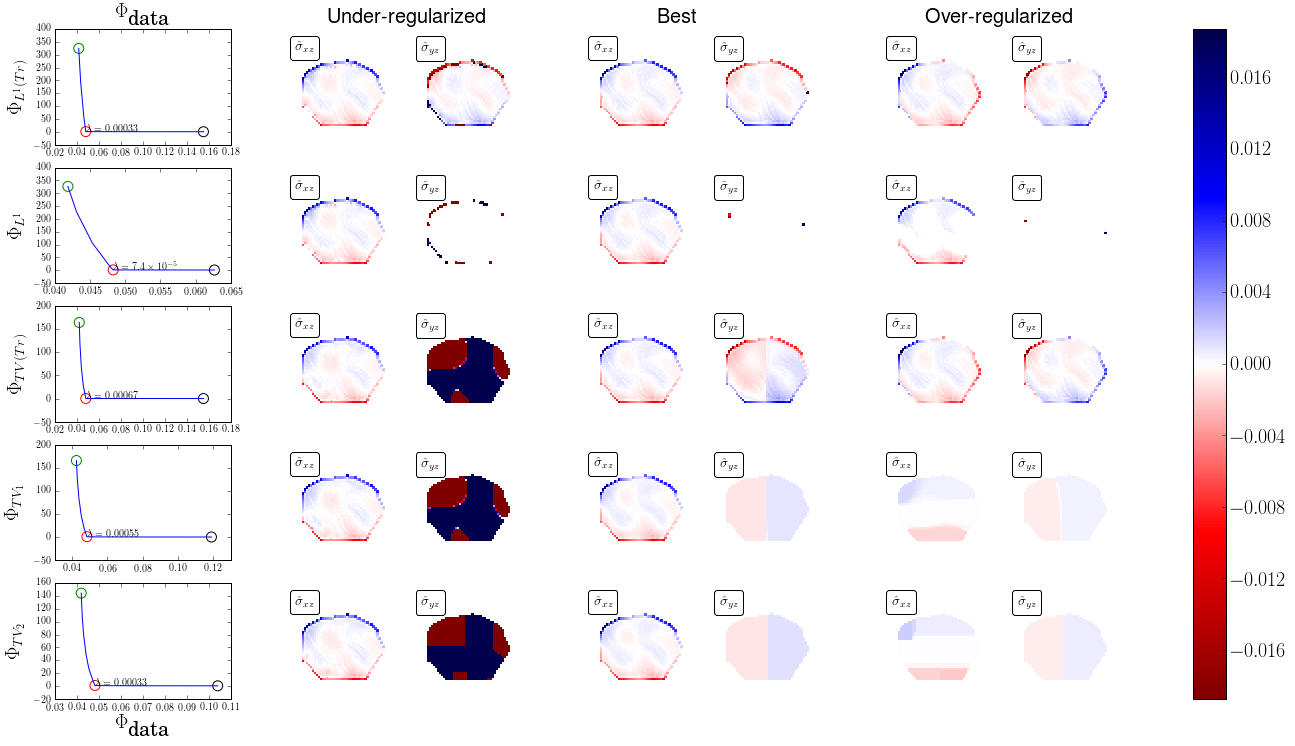

In [19]:
fig = plt.figure(figsize=(24,12))
ax = []
im = []

maxmagnitude = np.max(np.abs(results[0][-1][0]))
maxmagnitude = 0.025
gs0 = gridspec.GridSpec(5,1)

gs_j = []

gs_j_innergrids = []

for j in range(5):
    gs_j += [gridspec.GridSpecFromSubplotSpec(1,4,
                subplot_spec=gs0[j],hspace = 0.5,
                width_ratios = [0.7,1,1,1])]
                #height_ratios = [1,1,1,1,1,1,1])]
    gs_j_innergrids+= [[]]
    
    ax += [plt.Subplot(fig, gs_j[j][0,0])]
    fig.add_subplot(ax[-1])
    
    data_error = [res[2] for res in results[j]]
    reg_error = [res[3] for res in results[j]]
    lvals = [res[4] for res in results[j]]

    l_curve_distances = np.abs((reg_error[-1]-reg_error[0])*np.array(data_error) -  \
                (data_error[-1]-data_error[0])*np.array(reg_error)+data_error[-1]*reg_error[0]-reg_error[-1]*data_error[0])
    best = np.argsort(l_curve_distances)[-1]

    #plt.xlim((0.04,0.18))
    #plt.xticks(np.arange(0.04,0.18,0.02))
    ax[-1].plot( data_error, reg_error)
    ax[-1].scatter(data_error[best],reg_error[best],s=100, facecolors='none', edgecolors='r')
    ax[-1].scatter(data_error[0],reg_error[0],s=100, facecolors='none', edgecolors='g')
    ax[-1].scatter(data_error[-1],reg_error[-1],s=100, facecolors='none', edgecolors='black')

    #plt.xlabel("$\Phi$", fontsize=16)
    ax[-1].set_ylabel(Phi_labels[j], fontsize=20)
    #plt.title('', fontsize=16)
    #plt.text(data_error[best]*1.05,reg_error[best]*1.1,, horizontalalignment='left')
    ax[-1].annotate("$\quad\lambda=" + latex_float(lvals[best]) +"$", (data_error[best],reg_error[best]))
    # Plot the best recovery
    Fx = results[j][0][0][:,0].reshape((len(x_1),len(y_1))).transpose()
    Fy = results[j][0][0][:,1].reshape((len(x_1),len(y_1))).transpose()
    
    # under-regularized
    gs_j_innergrids[j] += [gridspec.GridSpecFromSubplotSpec(1,2,
            subplot_spec = gs_j[j][0,1], wspace=0.0, hspace = 0.0)]
    
    ax += [plt.Subplot(fig, gs_j_innergrids[j][0][0,0])]
    fig.add_subplot(ax[-1])
    
    ax[-1].set_xlim((x_min - 15, x_max + 15))
    ax[-1].set_ylim((y_min - 15, y_max + 25))
    plt.axis('off')

    z = np.ma.masked_array(Fx, np.abs(Fx) < 1e-5)
    im += [ax[-1].pcolormesh(x_1,y_1,z,
                        cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75)]
    
    im[-1].axes.set_aspect('equal')
    
    at = AnchoredText("$\hat{\sigma}_{xz}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)
    
    
    ax += [plt.Subplot(fig, gs_j_innergrids[j][0][0,1])]
    fig.add_subplot(ax[-1])
    
    ax[-1].set_xlim((x_min - 15, x_max + 15))
    ax[-1].set_ylim((y_min - 15, y_max + 25))
    plt.axis('off')
    at = AnchoredText("$\hat{\sigma}_{yz}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)
    
    z = np.ma.masked_array(Fy, np.abs(Fy) < 1e-5)
    ax[-1].pcolormesh(x_1,y_1,z,
                        cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75).axes.set_aspect('equal')
    
    gs_j_innergrids[j] += [gridspec.GridSpecFromSubplotSpec(1,2,
            subplot_spec = gs_j[j][0,2], wspace=0.0, hspace = 0.0)]    
    # Plot the best
    
    Fx = results[j][best][0][:,0].reshape((len(x_1),len(y_1))).transpose()
    Fy = results[j][best][0][:,1].reshape((len(x_1),len(y_1))).transpose()
    
    ax += [plt.Subplot(fig, gs_j_innergrids[j][1][0,0])]
    fig.add_subplot(ax[-1])
    
    ax[-1].set_xlim((x_min - 15, x_max + 15))
    ax[-1].set_ylim((y_min - 15, y_max + 25))
    plt.axis('off')
    
    at = AnchoredText("$\hat{\sigma}_{xz}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)

    z = np.ma.masked_array(Fx, np.abs(Fx) < 1e-5)    
    ax[-1].pcolormesh(x_1,y_1,z,
                        cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75).axes.set_aspect('equal')
    
    ax += [plt.Subplot(fig, gs_j_innergrids[j][1][0,1])]
    fig.add_subplot(ax[-1])
    
    ax[-1].set_xlim((x_min - 15, x_max + 15))
    ax[-1].set_ylim((y_min - 15, y_max + 25))
    plt.axis('off')
    
    at = AnchoredText("$\hat{\sigma}_{yz}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)
    
    z = np.ma.masked_array(Fy, np.abs(Fy) < 1e-5)        
    ax[-1].pcolormesh(x_1,y_1,z,
                        cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75).axes.set_aspect('equal')
    
    # plot the over-regularized
    gs_j_innergrids[j] += [gridspec.GridSpecFromSubplotSpec(1,2,
            subplot_spec = gs_j[j][0,3], wspace=0.0, hspace = 0.0)]
    
    Fx = results[j][-1][0][:,0].reshape((len(x_1),len(y_1))).transpose()
    Fy = results[j][-1][0][:,1].reshape((len(x_1),len(y_1))).transpose()
    
    ax += [plt.Subplot(fig, gs_j_innergrids[j][2][0,0])]
    fig.add_subplot(ax[-1])
    
    ax[-1].set_xlim((x_min - 15, x_max + 15))
    ax[-1].set_ylim((y_min - 15, y_max + 25))
    plt.axis('off')

    at = AnchoredText("$\hat{\sigma}_{xz}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")  
    
    ax[-1].add_artist(at)
    
    z = np.ma.masked_array(Fx, np.abs(Fx) < 1e-5)            
    ax[-1].pcolormesh(x_1,y_1,z,
                        cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75).axes.set_aspect('equal')
    
    ax += [plt.Subplot(fig, gs_j_innergrids[j][2][0,1])]
    fig.add_subplot(ax[-1])
    
    ax[-1].set_xlim((x_min - 15, x_max + 15))
    ax[-1].set_ylim((y_min - 15, y_max + 25))
    plt.axis('off')

    at = AnchoredText("$\hat{\sigma}_{yz}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")    
    
    ax[-1].add_artist(at)
    
    z = np.ma.masked_array(Fy, np.abs(Fy) < 1e-5)                
    ax[-1].pcolormesh(x_1,y_1,z,
                        cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.75).axes.set_aspect('equal') 
    
ax[-7].set_xlabel(r"$\Phi_{\textrm{data}}$",fontsize=20)
ax[0].set_title(r"$\Phi_{\textrm{data}}$",fontsize=20)

fig.colorbar(im[0], ax = ax).ax.tick_params(labelsize=20)

#plt.savefig("fig2.pdf",bbox_inches='tight', 
#               transparent=True,
#               pad_inches=0, dpi=400)

ax[1].text(90,220,r"Under-regularized",fontsize=20)
ax[3].text(115,220,r"Best",fontsize=20)
ax[5].text(90,220,r"Over-regularized",fontsize=20)

plt.savefig("../figures/fig2.png",bbox_inches='tight', 
               transparent=True,
               pad_inches=0.15, dpi=400)

#plt.savefig("../figures/fig2.pdf",bbox_inches='tight', 
#               transparent=True,
#               pad_inches=0, dpi=400)

#plt.show()


In [5]:
# do individual figures and use tikz to put it all together?

In [6]:
ax1 = ax[1]

In [7]:
ax1.text?

In [8]:
net_forces_x = [sum(res[0][:,0]) for res in results[0]]
net_forces_y = [sum(res[0][:,1]) for res in results[0]]